In [1]:
import networkit as nk

from networkit.community import LeidenAlgorithm, PLM

G_adjnoun = nk.readGraph('adjnoun.graph', nk.Format.METIS)

G_email = nk.readGraph('email.graph', nk.Format.METIS)

G_pgp = nk.readGraph('PGPgiantcompo.graph', nk.Format.METIS)

In [2]:
def genLFR(n, mu):
    lfr = nk.generators.LFRGenerator(n)
    lfr.generatePowerlawDegreeSequence(20, 50, -2)
    lfr.generatePowerlawCommunitySizeSequence(20, 100, -1)
    lfr.setMu(mu)
    lfr.run()
    return (lfr.getGraph(), lfr.getPartition())



## Evaluation mit LFR

In [3]:
mus = [i/10 for i in range(1, 10)]

In [4]:
import matplotlib.pyplot as plt
import leidenalg
import igraph as ig

Mu: 0.1
Mu: 0.2
Mu: 0.3
Mu: 0.4
Mu: 0.5
Mu: 0.6
Mu: 0.7
Mu: 0.8
Mu: 0.9


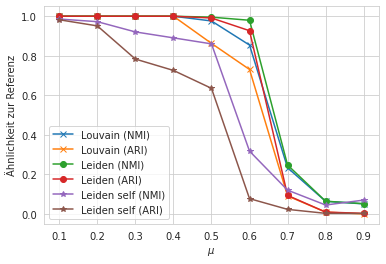

In [5]:
aris_louvain = []
nmis_louvain = []
aris_leiden = []
nmis_leiden = []
aris_leiden_self = []
nmis_leiden_self = []
for mu in mus:
    print('Mu: {}'.format(mu))
    # LFR
    Glfr, Plfr = genLFR(1000, mu)

    # Louvain
    Plouvain = nk.community.PLM(Glfr, par="none randomized").run().getPartition()
    aris_louvain.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Plouvain))
    nmis_louvain.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Plouvain))

    # Leidenalg
    Glfrig = ig.Graph(Glfr.numberOfNodes(), Glfr.iterEdges())
    Pleiden = leidenalg.find_partition(Glfrig, leidenalg.ModularityVertexPartition, n_iterations=20)
    Pnkleiden = nk.Partition(Glfr.numberOfNodes())
    Pnkleiden.setUpperBound(len(Pleiden))
    for i, c in enumerate(Pleiden):
        for u in c:
            Pnkleiden[u] = i

    aris_leiden.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Pnkleiden))
    nmis_leiden.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Pnkleiden))

    leiden = nk.community.LeidenAlgorithm(Glfr)

    for i in range(10):
        leiden.run()

    Pleiden_self = leiden.getPartition()
    aris_leiden_self.append(1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(Glfr, Plfr, Pleiden_self))
    nmis_leiden_self.append(1.0 - nk.community.NMIDistance().getDissimilarity(Glfr, Plfr, Pleiden_self))

fig, ax = plt.subplots()
ax.plot(mus, nmis_louvain, "x-", label="Louvain (NMI)")
ax.plot(mus, aris_louvain, "x-", label="Louvain (ARI)")
ax.plot(mus, nmis_leiden, "o-", label="Leiden (NMI)")
ax.plot(mus, aris_leiden, "o-", label="Leiden (ARI)")
ax.plot(mus, nmis_leiden_self, "*-", label="Leiden self (NMI)")
ax.plot(mus, aris_leiden_self, "*-", label="Leiden self (ARI)")

ax.set_xlabel("$\mu$")
ax.set_ylabel("Ähnlichkeit zur Referenz")
ax.legend()

In [6]:
def eval_louvain(G):
    louvain = nk.community.PLM(G, par="none randomized")
    louvain.run()

    Plouvain = louvain.getPartition()

    return Plouvain, Plouvain.numberOfSubsets(), nk.community.Modularity().getQuality(Plouvain, G)

In [7]:
def eval_leiden(G):
    G_ig = ig.Graph(G.numberOfNodes(), G.iterEdges())
    Pleiden = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, n_iterations=20)
    Pnkleiden = nk.Partition(G.numberOfNodes())
    Pnkleiden.setUpperBound(len(Pleiden))
    for i, c in enumerate(Pleiden):
        for u in c:
            Pnkleiden[u] = i

    return Pnkleiden, Pnkleiden.numberOfSubsets(), nk.community.Modularity().getQuality(Pnkleiden, G)


In [8]:
def eval_leiden_self(G):
    leiden_self = nk.community.LeidenAlgorithm(G)

    for i in range(10):
        leiden_self.run()

    P_leiden_self = leiden_self.getPartition()

    return P_leiden_self, P_leiden_self.numberOfSubsets(), nk.community.Modularity().getQuality(P_leiden_self, G)

## Adjnoun Graph (n = ~200, m = ~400)

In [9]:
G_adjnoun.numberOfNodes(), G_adjnoun.numberOfEdges()

(112, 425)

### Louvain

In [10]:
p_adj_louvain, adj_louvain_num_subsets, adj_louvain_modularity = eval_louvain(G_adjnoun)

adj_louvain_num_subsets, adj_louvain_modularity

(8, 0.30065051903114187)

(array([1., 1., 2., 2., 2., 0.]),
 array([ 0,  5, 10, 15, 20, 25, 30]),
 <BarContainer object of 6 artists>)

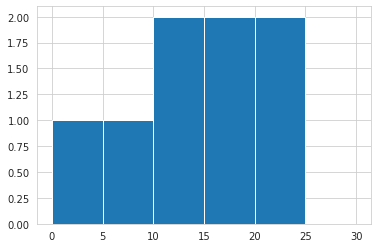

In [11]:
plt.hist(p_adj_louvain.subsetSizes(), bins=range(0, 35, 5))

### Leiden (leidenalg)

In [12]:
p_adj_leidenalg, adj_leidenalg_num_subsets, adj_leidenalg_modularity = eval_leiden(G_adjnoun)

adj_leidenalg_num_subsets, adj_leidenalg_modularity

(7, 0.3111169550173011)

(array([1., 0., 1., 3., 2., 0.]),
 array([ 0,  5, 10, 15, 20, 25, 30]),
 <BarContainer object of 6 artists>)

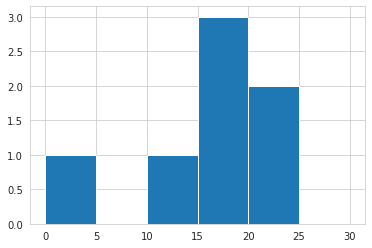

In [13]:
plt.hist(p_adj_leidenalg.subsetSizes(), bins=range(0, 35, 5))

### Leiden (self)

In [14]:
p_adj_leiden_self, adj_leiden_self_num_subsets, adj_leiden_self_modularity = eval_leiden_self(G_adjnoun)

adj_leiden_self_num_subsets, adj_leiden_self_modularity

(7, 0.23505605536332186)

(array([0., 2., 3., 0., 1., 0.]),
 array([ 0,  5, 10, 15, 20, 25, 30]),
 <BarContainer object of 6 artists>)

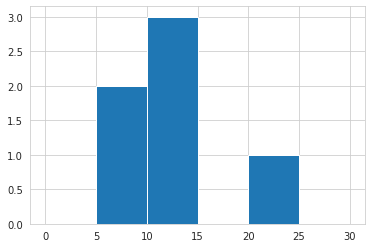

In [15]:
plt.hist(p_adj_leiden_self.subsetSizes(), bins=range(0, 35, 5))

### Comparison leidenalg vs self

In [16]:
nmi_sim = 1.0 - nk.community.NMIDistance().getDissimilarity(G_adjnoun, p_adj_leidenalg, p_adj_leiden_self)
arm_sim = 1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(G_adjnoun, p_adj_leidenalg, p_adj_leiden_self)

nmi_sim, arm_sim

(0.479814576283075, 0.26636314072827094)

## Email Graph (n = ~1000, m = ~5000)

In [17]:
G_email.numberOfNodes(), G_email.numberOfEdges()

(1133, 5451)

### Louvain

In [18]:
p_email_louvain, email_louvain_num_subsets, email_louvain_modularity = eval_louvain(G_email)

email_louvain_num_subsets, email_louvain_modularity

(12, 0.5686229590480066)

(array([0., 1., 2., 2., 3., 0., 2., 0., 2., 0., 0., 0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <BarContainer object of 12 artists>)

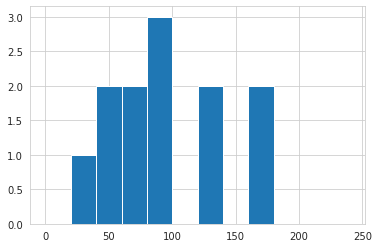

In [19]:
plt.hist(p_email_louvain.subsetSizes(), bins=range(0, 250, 20))

### Leiden (leidenalg)

In [20]:
p_email_leidenalg, email_leidenalg_num_subsets, email_leidenalg_modularity = eval_leiden(G_email)

email_leidenalg_num_subsets, email_leidenalg_modularity

(11, 0.5793611104969102)

(array([0., 0., 1., 4., 1., 1., 2., 0., 1., 1., 0., 0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <BarContainer object of 12 artists>)

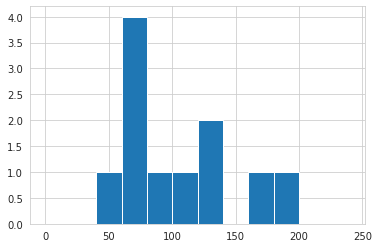

In [21]:
plt.hist(p_email_leidenalg.subsetSizes(), bins=range(0, 250, 20))

### Leiden (self)

In [22]:
p_email_leiden_self, email_leiden_self_num_subsets, email_leiden_self_modularity = eval_leiden_self(G_email)

email_leiden_self_num_subsets, email_leiden_self_modularity

(12, 0.5303971261990508)

(array([0., 0., 2., 4., 2., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480]),
 <BarContainer object of 24 artists>)

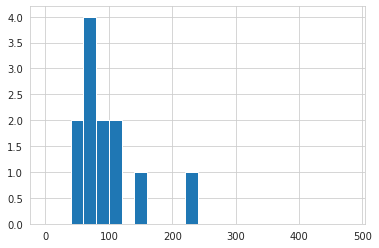

In [23]:
plt.hist(p_email_leiden_self.subsetSizes(), bins=range(0, 500, 20))

### Comparison leidenalg vs self

In [24]:
1.0 - nk.community.NMIDistance().getDissimilarity(G_email, p_email_leidenalg, p_email_leiden_self)

0.6528144985886558

In [25]:
1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(G_email, p_email_leidenalg, p_email_leiden_self)

0.5772163588072373

## PGP Graph (n = ~10000, m = ~25000)

In [26]:
G_pgp.numberOfNodes(), G_pgp.numberOfEdges()

(10680, 24316)

### Louvain

In [27]:
p_pgp_louvain, pgp_louvain_num_subsets, pgp_louvain_modularity = eval_louvain(G_pgp)

pgp_louvain_num_subsets, pgp_louvain_modularity

(96, 0.8840724879520595)

(array([23., 16., 15.,  4.,  2.,  3.,  4.,  2.,  5.,  3.,  2.,  2.,  2.,
         2.,  1.,  2.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,  0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480]),
 <BarContainer object of 24 artists>)

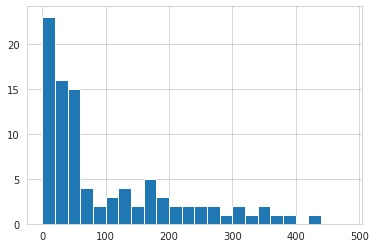

In [28]:
plt.hist(p_pgp_louvain.subsetSizes(), bins=range(0, 500, 20))

### Leiden (leidenalg)

In [29]:
p_pgp_leidenalg, pgp_leidenalg_num_subsets, pgp_leidenalg_modularity = eval_leiden(G_pgp)

pgp_leidenalg_num_subsets, pgp_leidenalg_modularity

(96, 0.8865609328845369)

(array([27., 12., 13.,  6.,  4.,  5.,  2.,  2.,  2.,  4.,  2.,  2.,  1.,
         3.,  0.,  1.,  3.,  1.,  0.,  2.,  0.,  2.,  0.,  0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480]),
 <BarContainer object of 24 artists>)

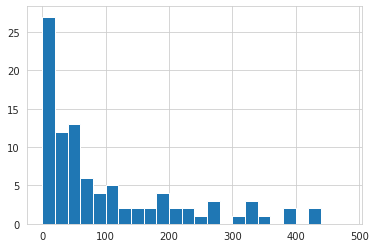

In [30]:
plt.hist(p_pgp_leidenalg.subsetSizes(), bins=range(0, 500, 20))

### Leiden (self)

In [31]:
p_pgp_leiden_self, pgp_leiden_self_num_subsets, pgp_leiden_self_modularity = eval_leiden_self(G_pgp)

pgp_leiden_self_num_subsets, pgp_leiden_self_modularity

(99, 0.877988281845648)

(array([29., 16., 17.,  4.,  4.,  1.,  4.,  2.,  2.,  3.,  2.,  0.,  2.,
         2.,  1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480]),
 <BarContainer object of 24 artists>)

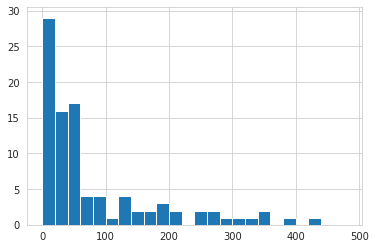

In [35]:
plt.hist(p_pgp_leiden_self.subsetSizes(), bins=range(0, 500, 20))

### Comparison leidenalg vs self

In [33]:
1.0 - nk.community.NMIDistance().getDissimilarity(G_pgp, p_pgp_leidenalg, p_pgp_leiden_self)

0.8680351773017018

In [34]:
1.0 - nk.community.AdjustedRandMeasure().getDissimilarity(G_pgp, p_pgp_leidenalg, p_pgp_leiden_self)

0.6524057368946677